# G2. 멋진 단어사전 만들기

- 소설책 1권 분량의 텍스트를 lecture에서 다룬 다양한 디법으로 전처리하여 단어사전을 만들어 본다. 각각의 단어사전을 토대로 언어 모델을 생성하여 perplexity를 측정해보고 어떤 기법의 성능이 우수한지 평가해본다. 
- 이번 코스에서는 문장 데이터를 직접 토큰화하며 어떤 방법이 가장 적합한 단어 조각을 만들어 내는지 실습해보자.

****

# 프로젝트: SentencePiece 사용하기

****

## Step 1. SentencePiece 설치하기

- SentencePiece는 구글에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도롣 패키징한 것이다. 
- 상세 내용을 담은 웹 페이지: [google/sentencepiece](https://github.com/google/sentencepiece)


- 위 웹 페이지 서두에서도 언듭하고 있듯이 SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 사용하면서 사실상 표준의 역할을 하고 있다. 앞으로 많이 볼 것이니 친해지는 것이 좋다.


- SentencePiece는 파이썬에서 쓰하고 만든 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있다.
```
$ pip install sentencepiece
```

****

## Step 2. SentencePiece 설치하기

- 앞에서 배운 ```tokenize()```함수에서 ```tf.keras.preprocessing.text.Tokenizer```에 corpus를 주고 ```tokenizer.fit_on_texts(corpus)```을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동생성해 주는 것이다.
```
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
```


- 이를 위해선 SentencePiece 모델을 학습하는 과정을 거쳐야 한다. 아래 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 koreanspm.model 파일과 koreanspm.vocab 파일이 생성됨을 확인할 수 있다.

In [ ]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있음.
# --model_type = 'bpe' 로 옵션을 주어 변경할 수 있음.

!ls -l korean_spm*

- 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보자.

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

****

## Step 3. Tokenizer 함수 작성

- 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 ```sp_tokenize()``` 함수를 정의해볼 것이다.
- 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 당아 완전히 동일하게는 정의하기 어렵다. 따라서 아래 조건을 만족하는 함수를 정의하도록 하겠다.

> 1. 매개변수로 토큰화된 문장의 ```list```를 전달하는 대신 **온전한 문장**의 ```list```를 전달한다.
> 2. **생성된 vocab 파일**을 읽어와 ```{ <word> : <index> }``` 형태를 가지는 ```index_word``` 사전을 생성하고 함께 **반환**한다.
> 3. 리턴값인 ```tensor```는 앞의 함수와 동일하게 토큰화 한 후 인코딩된 문장이다. 바로 학습에 사용할 수 있게 Padding을 하자.

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)
# print(word_index)
# print(index_word)

****

## Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

- [네이버 영화리뷰 감정분석 태스크](https://github.com/e9t/nsmc/)
- 한국어로 된 코퍼스를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전저치래서 RNN 모델을 분류기로 사용했을 것이다.
- 만약 이 문제에서 tokenizer를 sentencepiece로 바꿔 다시 풀어본다면 성능이 좋아질지 비교해보자.

> - 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기
> - 학습된 모델로 sp_tokenize() 메소드 구현하기
> - 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기
> - KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
> - (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
> - Word Vector는 활용할 필요가 없고 활용이 가능하지도 않을 것이다.
> - 머지 않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것이다.

### 데이터 준비하기

- 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)를 다운받아줍니다. 해당 파일은 20만개의 리뷰로 이루어져다.

```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sp_tokenizer/data
```

In [31]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train_data.head()

train 데이터 사이즈: 150000
test 데이터 사이즈: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# 중복 및 결측치 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train 데이터 사이즈: 146182
test 데이터 사이즈: 49157


- 훈련 데이터와 시험 데이터를 하나로 통합시켜 데이터 전처리를 진행하겠다.

In [5]:
data = list(train_data['document']) + list(test_data['document'])

print("Data Size:", len(data))

print("Example:")
for sen in data[0:100][::20]: print(">>", sen)

Data Size: 195339
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


### 데이터 정제하기

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


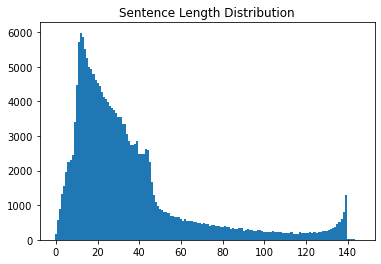

In [6]:
# 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이분포를 막대그래프로 표현해주는 소스
min_len = 999
max_len = 0
sum_len = 0

for sen in data: 
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [7]:
# 길이 체크 함수로 문장 길이 확인하기
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

# 훈련 데이터 길이가 1인 문장 확인해보기            
check_sentence_with_length(data, 1)
print("-------------------------------------")
# 훈련 데이터 길이가 146인 문장 확인해보기            
check_sentence_with_length(data, 146)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡
-------------------------------------
"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


In [8]:
# 길이 별로 확인이 필요해보이는 문장 확인하기
for idx, _sum in enumerate(sentence_length):
    # 문장 내 단어의 개수가 5000을 초과하는 인덱스를 추출
    if _sum > 5000:
        print("Outlier Index:", idx+1)

Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17


In [9]:
check_sentence_with_length(data, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


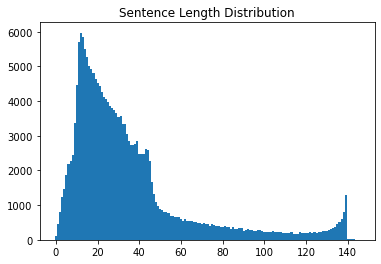

In [10]:
# 데이터에서 중복 제거하기
min_len= 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(data))  # set를 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

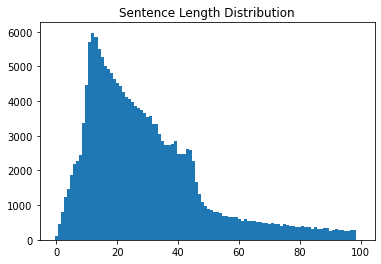

In [11]:
max_len = 100
min_len = 1

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려보자 
# 아래 나온 그래프는 최종 데이터 분포
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

****

### 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

- unigram과 bpe 타입 model 파일과 vocal 파일을 각각 하나씩 만들어서 확인해보자.

In [12]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# 디폴트 --model_type = 'unigram'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

# --model_type = 'bpe'
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=naver_review_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l naver_review_spm*

-rw-r--r-- 1 aiffel-dj20 aiffel-dj20 375100  4월 19 21:09 naver_review_spm.model
-rw-r--r-- 1 aiffel-dj20 aiffel-dj20 144530  4월 19 21:09 naver_review_spm.vocab
-rw-r--r-- 1 aiffel-dj20 aiffel-dj20 370616  4월 19 21:09 naver_review_spm_bpe.model
-rw-r--r-- 1 aiffel-dj20 aiffel-dj20 115824  4월 19 21:09 naver_review_spm_bpe.vocab


#### Unigram 타입

In [13]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_uni = spm.SentencePieceProcessor() 
s_uni.Load('naver_review_spm.model') # unigram 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[1510, 9, 406, 15, 1345, 9, 138, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


#### BPE 타입

In [14]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_bpe = spm.SentencePieceProcessor() 
s_bpe.Load('naver_review_spm_bpe.model') # bpe 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[5065, 913, 6551, 6283, 1472, 6279, 6385, 6273, 6271]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


****

### 학습된 모델로 sp_tokenize() 메소드 구현하기

#### Unigram 타입

In [16]:
def sp_tokenize_uni(s_uni, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))

    with open("./naver_review_spm.vocab", 'r') as f: # unigram 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인해
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, my_corpus)
print(tensor_uni)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  562 3393   14 1380
  2219    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1581 2277  253  590

In [17]:
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, data)

In [18]:
print(tensor_uni.shape)

(195339, 100)


#### BPE 타입

In [20]:
def sp_tokenize_bpe(s_bpe, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s_bpe.EncodeAsIds(sen))

    with open("./naver_review_spm_bpe.vocab", 'r') as f: # bpe 타입 vocab
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen = 100)

    return tensor, word_index, index_word

#sp_tokenize(s, corpus) 사용예제로 확인해
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, my_corpus)
print(tensor_bpe)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  721 3152 6300  567
   833 6271]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 1684 2307  320

In [21]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, data)

In [22]:
print(tensor_bpe.shape)

(195339, 100)


****

### 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

- Unigram 타입을 적용한 토크나이저를 적용하여 RNN 모델 학습해보자.
- 합쳐진 데이터를 분할하고, 검증 데이터도 분할해주자. 

In [23]:
# 데이터 분할
X_train = tensor_uni[:146182]
X_test = tensor_uni[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 12)                1392      
_________________________________________________________________
dense (Dense)                (None, 8)                 104       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 9s 44ms/step - loss: 0.6263 - accuracy: 0.6818 - val_loss: 0.3749 - val_accuracy: 0.8447
Epoch 2/20
188/188 [==============================] - 8s 40ms/step - loss: 0.3453 - accuracy: 0.8569 - val_loss: 0.3479 - val_accuracy: 0.8520
Epoch 3/20
188/188 [==============================] - 8s 42ms/step - loss: 0.3102 - accuracy: 0.8716 - val_loss: 0.3503 - val_accuracy: 0.8483
Epoch 4/20
188/188 [==============================] - 8s 41ms/step - loss: 0.3012 - accuracy: 0.8760 - val_loss: 0.3465 - val_accuracy: 0.8524
Epoch 5/20
188/188 [==============================] - 8s 44ms/step - loss: 0.2918 - accuracy: 0.8799 - val_loss: 0.3472 - val_accuracy: 0.8524
Epoch 6/20
188/188 [==============================] - 8s 41ms/step - loss: 0.2849 - accuracy: 0.8835 - val_loss: 0.3478 - val_accuracy: 0.8517
Epoch 7/20
188/188 [==============================] - 8s 44ms/step - loss: 0.2749 - accuracy: 0.8881 - val_loss: 0.3467 - val_accuracy: 0.8516

1537/1537 - 5s - loss: 0.5276 - accuracy: 0.8333
[0.5275934934616089, 0.8333095908164978]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


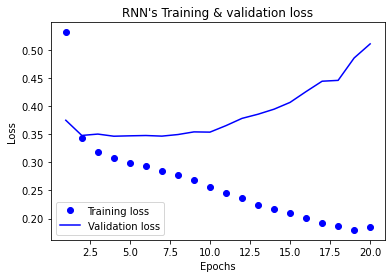

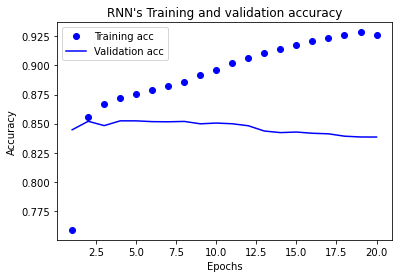

In [26]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- BPE 타입을 적용한 토크나이저를 적용하여 RNN 모델 학습해보자.
- 합쳐진 데이터를 분할하고, 검증 데이터도 분할해주자.

In [27]:
# 데이터 분할
X_train = tensor_bpe[:146182]
X_test = tensor_bpe[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 100)
(96182,)


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 10s 44ms/step - loss: 0.6441 - accuracy: 0.6639 - val_loss: 0.3928 - val_accuracy: 0.8387
Epoch 2/20
188/188 [==============================] - 8s 43ms/step - loss: 0.3614 - accuracy: 0.8507 - val_loss: 0.3543 - val_accuracy: 0.8463
Epoch 3/20
188/188 [==============================] - 8s 42ms/step - loss: 0.3167 - accuracy: 0.8702 - val_loss: 0.3481 - val_accuracy: 0.8518
Epoch 4/20
188/188 [==============================] - 8s 43ms/step - loss: 0.2981 - accuracy: 0.8785 - val_loss: 0.3497 - val_accuracy: 0.8493
Epoch 5/20
188/188 [==============================] - 8s 41ms/step - loss: 0.2854 - accuracy: 0.8843 - val_loss: 0.3474 - val_accuracy: 0.8523
Epoch 6/20
188/188 [==============================] - 8s 42ms/step - loss: 0.2770 - accuracy: 0.8892 - val_loss: 0.3525 - val_accuracy: 0.8491
Epoch 7/20
188/188 [==============================] - 8s 42ms/step - loss: 0.2655 - accuracy: 0.8923 - val_loss: 0.3530 - val_accuracy: 0.850

1537/1537 - 5s - loss: 0.6079 - accuracy: 0.8321
[0.6079005599021912, 0.8320890069007874]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


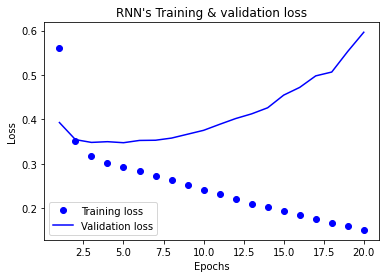

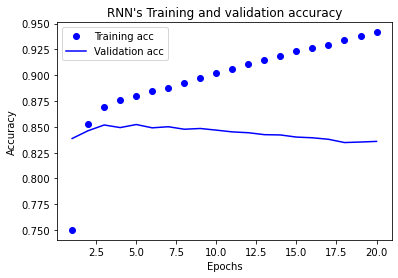

In [30]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

****

### KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴


- 위 내용으로 로더를 구성한다.

In [35]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [36]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [37]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

- 모델 구성을 위한 데이터 분석 및 가공을 해주자.

In [38]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [39]:
# 데이터셋 내 문장 길이 분포 파악
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [40]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [41]:
# 적절한 최대 문장 길이를 지정
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 설정  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [42]:
# 패딩 작업
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


- RNN 모델 구성 및 검증 데이터셋을 구성해주자.

In [45]:
#  validation set 구성
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(12))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 161,505
Trainable params: 161,505
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 20ms/step - loss: 0.6231 - accuracy: 0.6735 - val_loss: 0.3870 - val_accuracy: 0.8391
Epoch 2/20
188/188 [==============================] - 4s 20ms/step - loss: 0.3646 - accuracy: 0.8479 - val_loss: 0.3543 - val_accuracy: 0.8468
Epoch 3/20
188/188 [==============================] - 3s 18ms/step - loss: 0.3221 - accuracy: 0.8683 - val_loss: 0.3519 - val_accuracy: 0.8481
Epoch 4/20
188/188 [==============================] - 3s 18ms/step - loss: 0.3077 - accuracy: 0.8748 - val_loss: 0.3533 - val_accuracy: 0.8483
Epoch 5/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2947 - accuracy: 0.8814 - val_loss: 0.3569 - val_accuracy: 0.8466
Epoch 6/20
188/188 [==============================] - 3s 18ms/step - loss: 0.2907 - accuracy: 0.8830 - val_loss: 0.3615 - val_accuracy: 0.8457
Epoch 7/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2830 - accuracy: 0.8863 - val_loss: 0.3688 - val_accuracy: 0.8447

1537/1537 - 3s - loss: 0.4759 - accuracy: 0.8339
[0.4759012460708618, 0.8338995575904846]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


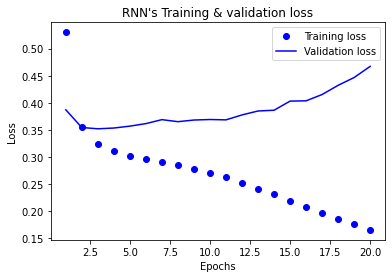

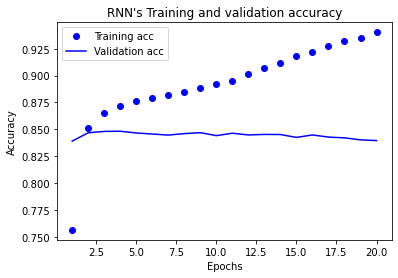

In [49]:
# 평가하기
results_rnn = model_rnn.evaluate(X_test, y_test, verbose=2)
print(results_rnn)

history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# train과 val의 Loss
acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# train과 val의 accuracy
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

****

# 루브릭 평가

|평가문항|상세기준|
|:-----|:-----|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

1. 처음에는 주어진 train, test 데이터의 규격을 지켜야 한다는 생각에 따로 전처리를 진행했는데, 주비터 노트북의 길이가 너무 길어지는 것을 보고 내 판단이 틀렸다는 것을 알았다. 어떻게 해야할지 몰랐는데 지효님의 깃헙에서 단서를 얻었다. 데이터들을 list로 변환해서 합치는 방법이었다. 이렇게 쉬운 방법이 있었다니! 나는 pandas만 가지고 5시간 이상을 씨름하고 있었는데! 나는 정말 데이터를 보는 눈이 없는 것 같다. 어떻게 하다보니 document 열 내용이랑 label 열 내용이 \t로 이어져서 이걸 또 슬라이싱으로 나눈다고 별짓을 다했었다. 진짜 지효님이 사람 하나 살리셨다. 전처리를 완료하고 나니 나머지는 어렵지 않았다. 직접 짜야하는 코드가 없고 E4의 코드를 가져다가 쓰는 부분도 있었기 때문이다. 모델이 제대로 돌아가는 것을 보니 모든 구현과 동작이 빠짐없는 것 같다.


2. Unigram 타입을 적용한 토크나이저랑 같이 돌린 RNN 모델은 83.33%의 정확성을 보여줬다. BPE 타입을 적용한 토크나이저랑 같이 돌린 RNN 모델은 83.21%의 정확성을 보여줬다. KoNLPy 형태소 분석기와 함께 돌린 RNN 모델은 83.39%의 정확성을 보여줬다. 


3. sentencepiece같은 subword 기반 토큰화보다 형태소 분석기가 좋은 성능을 내는 사례들이 종종 있다더니 이번이 그런 경우인가보다. 위 결과를 보면 형태소 분석기가 정확도가 더 높음을 볼 수 있다. 노드에 unigram에 대한 설명이 없는 것 같아서 BPE가 더 성능이 좋을 줄 알았는데, unigram보다 BPE가 아주 약간 정확도가 높고 성능에는 별반 차이가 없는 것 같다. 이번 프로젝트에서는 OOV 문제가 크게 걸림돌이 되지 않은 것일까?  

# 회고

기한이 2주로 늘어나서 나는 일찍 끝내고 다른 공부를 할 줄 알았는데, 웬걸... 진짜 미룰 때까지 미루고 마감 직전에 골머리를 썪는구나. 쉬울 거라고 생각했는데 데이터 전처리부터 골머리를 썪어보니 내가 잘못 생각하고 있다는 것을 확연하게 알았다. 목요일에 제출해야하는 것도 빨리 해야겠다. 그건 노드도 복습해야하는데... 아이고!


형태소 분석기나 subword 기반 토크나이저가 별반 차이가 없어서 조금 실망스러웠다. OOV 문제를 해결한다는 것이 내게는 정말 멋지게 다가왔기 때문이었다. 성능 차이가 더 있었다면 조금 더 설렜을지도 모른다.


그래도 자연어처리 프로젝트만 한다니 정말 자연어처리 반인 것이 이제야 실감이 난다. 설레는데 힘들다. (ㅎㅅㅎ) 

감상 끝.